In [1195]:
import torch
import os
import numpy as np
import utils.gradientUtils as gu
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.animation import PillowWriter
from io import BytesIO
from PIL import Image
from itertools import product
import pandas as pd

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))


stop_train_threshold = 1e-6
max_iter = 100
learning_rate = 0.03

radius = 3.0
origin = torch.tensor([5.0, 5.0], device=device)
half_sizes = torch.tensor([2, 4], device=device)


#sdf = 'circle'
#sdf = 'thorus'
#sdf = 'box'


destination = "./images/autograd/multiple_sites/"

Using device:  NVIDIA GeForce RTX 3090


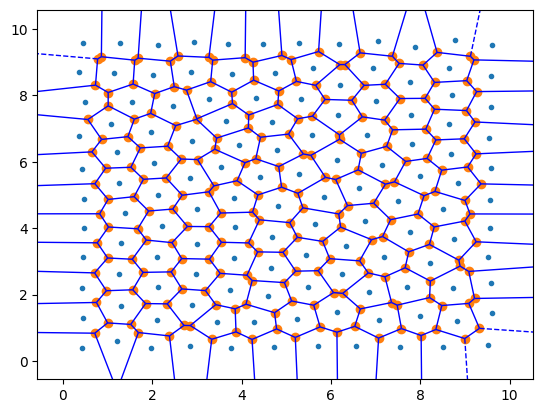

In [1196]:
# Python code for creating a CVT
# Vassilis Vassiliades - Inria, Nancy - April 2018

import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import argparse

# Default values
num_centroids = 128
dimensionality = 2
num_samples = 100000
num_replicates = 1
max_iterations = 100000
tolerance = 0.00001
verbose = True

X = np.random.rand(num_samples,dimensionality)

kmeans = KMeans(
    init='k-means++', 
    n_clusters=num_centroids, 
    n_init=num_replicates, 
    #n_jobs=-1, 
    max_iter=max_iterations, 
    tol=tolerance,
    verbose=0)

kmeans.fit(X)
centroids = kmeans.cluster_centers_
vor = Voronoi(centroids*10)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='blue')
# Plot the points
#plt.savefig('CVT_'f'{num_centroids}''.png',transparent=True)
plt.show()


In [1197]:
centroids = np.array(centroids) * 10.0
sites = torch.from_numpy(centroids).to(device).requires_grad_(True)


In [1198]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors


In [1199]:
def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

In [1200]:
def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and  for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])


In [1201]:
#SDF FUNCTIONS FOR TESTING
def circle_sdf(vertices, radius=radius, origin=origin):
    # Calculate the Euclidean distance of each vertex to the specified origin
    distances = torch.norm(vertices - origin, dim=1)  # L2 norm along x and y for each vertex
    # Calculate the SDF value: distance to origin minus the circle radius
    sdf_values = distances - radius
    return sdf_values

def box_sdf(vertices, origin=origin, half_sizes=half_sizes):
    """
    Computes the signed distance function (SDF) for a 2D rectangular box.
    
    Args:
        vertices (torch.Tensor): A tensor of shape (N, 2) containing the 2D points.
        origin (torch.Tensor): A tensor of shape (2,) specifying the center of the rectangle.
        half_sizes (torch.Tensor): A tensor of shape (2,) specifying half the width and height of the rectangle.
        
    Returns:
        torch.Tensor: A tensor of shape (N,) containing the SDF values.
    """
    # Compute distances to the box boundaries relative to the origin
    relative_vertices = torch.abs(vertices - origin) - half_sizes

    # Exterior distance: Euclidean distance from the nearest boundary
    outside_dist = torch.clamp(relative_vertices, min=0)
    outside_sdf = torch.norm(outside_dist, dim=1)
    
    # Interior distance: Maximum negative distance to any boundary
    inside_sdf = torch.amax(relative_vertices, dim=1)
    
    # Combine inside and outside distances
    sdf_values = torch.where(inside_sdf > 0, outside_sdf, inside_sdf)
    return sdf_values

def torus_sdf(vertices, r_inner=radius/2, r_outer=radius, origin=origin):
    """
    Compute the SDF loss for a 2D torus (ring) given a set of vertices.

    Parameters:
        vertices (torch.Tensor): Tensor of shape (N, 2), where each row is a 2D vertex.
        r_inner (float): Inner radius of the torus (ring).
        r_outer (float): Outer radius of the torus (ring).
        origin (torch.Tensor): Origin of the torus (center), a tensor of shape (2,).

    Returns:
        torch.Tensor: Signed distance values for each vertex, shape (N,).
    """
    # Calculate the Euclidean distance of each vertex to the torus origin
    distances_to_center = torch.norm(vertices - origin, dim=1)  # L2 norm along x and y for each vertex

    # Compute the unsigned distance to the ring
    unsigned_distance = torch.abs(distances_to_center - r_outer)
    
    # Compute the SDF
    sdf_values = unsigned_distance - (r_outer - r_inner)
    
    return sdf_values

def star_sdf(vertices, r=radius, rf=0.5, origin=origin):
    """
    Compute the SDF of a five-pointed star with a custom origin.

    Args:
        vertices (torch.Tensor): Input points, shape (N, 2).
        r (float): Outer radius of the star.
        rf (float): Ratio between the inner and outer radii of the star.
        origin (tuple): The origin of the star (x, y).

    Returns:
        torch.Tensor: SDF values for each point, shape (N,).
    """
    # Shift points relative to the origin
    p = vertices - origin

    # Define constants
    k1 = torch.tensor([0.809016994375, -0.587785252292], device=p.device, dtype=p.dtype)  # Cosine and sine for 72 degrees
    k2 = torch.tensor([-0.809016994375, -0.587785252292], device=p.device, dtype=p.dtype)  # Cosine and sine for -72 degrees

    # Reflect and transform the points without in-place modification
    p_reflected_x = torch.abs(p[:, 0]).unsqueeze(1)  # Reflect across the y-axis
    p_reflected = torch.cat((p_reflected_x, p[:, 1].unsqueeze(1)), dim=1)

    p_reflected -= 2.0 * torch.clamp(torch.sum(p_reflected * k1, dim=1, keepdim=True), min=0.0) * k1
    p_reflected -= 2.0 * torch.clamp(torch.sum(p_reflected * k2, dim=1, keepdim=True), min=0.0) * k2

    # Reflect again across the y-axis
    p_reflected_x2 = torch.abs(p_reflected[:, 0]).unsqueeze(1)
    p_reflected = torch.cat((p_reflected_x2, p_reflected[:, 1].unsqueeze(1)), dim=1)

    # Shift downwards
    p_reflected_y_shift = (p_reflected[:, 1] - r).unsqueeze(1)
    p_reflected = torch.cat((p_reflected[:, 0].unsqueeze(1), p_reflected_y_shift), dim=1)

    # Vector to the inner vertices
    ba = rf * torch.tensor([-k1[1], k1[0]], device=p.device, dtype=p.dtype) - torch.tensor([0, 1], device=p.device, dtype=p.dtype)
    
    # Projection along ba
    h = torch.clamp(torch.sum(p_reflected * ba, dim=1) / torch.sum(ba * ba), min=0.0, max=r)
    
    # Compute distance and sign
    dist = torch.norm(p_reflected - h.unsqueeze(1) * ba, dim=1)
    sign = torch.sign(p_reflected[:, 1] * ba[0] - p_reflected[:, 0] * ba[1])
    
    return dist * sign

def moon_sdf(vertices, d=0.5*radius, ra=1.0*radius, rb=0.8*radius, origin=origin):
    """
    Compute the SDF of a croissant-like shape with a custom origin.

    Args:
        vertices (torch.Tensor): Input points, shape (N, 2).
        d (float): Distance between the centers of the circles.
        ra (float): Radius of the larger circle.
        rb (float): Radius of the smaller circle.
        origin (tuple): The origin of the croissant (x, y).

    Returns:
        torch.Tensor: SDF values for each point, shape (N,).
    """
    # Shift points relative to the origin
    p = vertices - origin
    
    # Reflect across the x-axis (croissant symmetry) without in-place modification
    p_reflected = torch.clone(p)
    p_reflected[:, 1] = torch.abs(p[:, 1])
    
    # Compute parameters of the crescent
    a = (ra**2 - rb**2 + d**2) / (2.0 * d)
    b = torch.sqrt(torch.clamp(torch.tensor(ra**2 - a**2, device=p.device, dtype=p.dtype), min=0.0))
    
    # Vector to the offset circle
    offset = torch.tensor([a, b], device=p.device, dtype=p.dtype)
    
    # Check point location relative to crescent
    condition = d * (p_reflected[:, 0] * b - p_reflected[:, 1] * a) > d**2 * torch.clamp(b - p_reflected[:, 1], min=0.0)
    
    # SDF computation
    dist_to_outer_circle = torch.norm(p_reflected - offset, dim=1)
    dist_to_inner_circle = torch.norm(p_reflected - torch.tensor([d, 0.0], device=p.device, dtype=p.dtype), dim=1)
    dist_to_main_circle = torch.norm(p_reflected, dim=1)
    
    sdf_values = torch.where(
        condition,
        dist_to_outer_circle,
        torch.max(
            dist_to_main_circle - ra,
            -(dist_to_inner_circle - rb)
        )
    )
    
    return sdf_values

# def wave_sdf(vertices, tb=1.0, ra=0.3, origin=origin):
#     """
#     Compute the SDF of a wave-like circular pattern.

#     Args:
#         vertices (torch.Tensor): Input points, shape (N, 2).
#         tb (float): Angular scaling parameter (e.g., wave frequency).
#         ra (float): Radius of the base circle.

#     Returns:
#         torch.Tensor: SDF values for each point, shape (N,).
#     """
#     # Ensure tb is positive and scale it
#     tb = torch.tensor(tb, device=vertices.device, dtype=vertices.dtype)  # Convert tb to a tensor
#     tb = torch.pi * 5.0 / 6.0 * torch.clamp(tb, min=0.0001)

#     # Compute the wave circle's control vector
#     co = ra * torch.stack([torch.sin(tb), torch.cos(tb)])

#     # Reflect and modularize the points
#     p = torch.clone(vertices)
#     p[:, 0] = torch.abs(p[:, 0] % (co[0] * 4.0) - co[0] * 2.0)

#     # Compute transformed points
#     p1 = p
#     p2 = torch.stack([torch.abs(p[:, 0] - 2.0 * co[0]), -p[:, 1] + 2.0 * co[1]], dim=1)

#     # Compute distances for both conditions
#     d1 = torch.where(
#         co[1] * p1[:, 0] > co[0] * p1[:, 1],
#         torch.norm(p1 - co, dim=1),
#         torch.abs(torch.norm(p1, dim=1) - ra)
#     )
#     d2 = torch.where(
#         co[1] * p2[:, 0] > co[0] * p2[:, 1],
#         torch.norm(p2 - co, dim=1),
#         torch.abs(torch.norm(p2, dim=1) - ra)
#     )

#     # Return the minimum distance
#     return torch.min(d1, d2)-0.03
def wave_sdf(vertices, tb=1.0, ra=radius/2, origin=origin):
    """
    Compute the SDF of a wave-like circular pattern with a custom origin.

    Args:
        vertices (torch.Tensor): Input points, shape (N, 2).
        tb (float): Angular scaling parameter (e.g., wave frequency).
        ra (float): Radius of the base circle.
        origin (torch.Tensor): Center of the wave pattern, shape (2,).

    Returns:
        torch.Tensor: SDF values for each point, shape (N,).
    """
    # Shift vertices relative to the origin
    p = vertices - origin

    # Ensure tb is positive and scale it
    tb = torch.tensor(tb, device=vertices.device, dtype=vertices.dtype)  # Convert tb to a tensor
    tb = torch.pi * 5.0 / 6.0 * torch.clamp(tb, min=0.0001)

    # Compute the wave circle's control vector
    co = ra * torch.stack([torch.sin(tb), torch.cos(tb)])

    # Reflect and modularize the points
    p_reflected_x = torch.abs(p[:, 0] % (co[0] * 4.0) - co[0] * 2.0).unsqueeze(1)
    p_reflected = torch.cat((p_reflected_x, p[:, 1].unsqueeze(1)), dim=1)

    # Compute transformed points
    p1 = p_reflected
    p2 = torch.stack([
        torch.abs(p_reflected[:, 0] - 2.0 * co[0]),
        -p_reflected[:, 1] + 2.0 * co[1]
    ], dim=1)

    # Compute distances for both conditions
    d1 = torch.where(
        co[1] * p1[:, 0] > co[0] * p1[:, 1],
        torch.norm(p1 - co, dim=1),
        torch.abs(torch.norm(p1, dim=1) - ra)
    )
    d2 = torch.where(
        co[1] * p2[:, 0] > co[0] * p2[:, 1],
        torch.norm(p2 - co, dim=1),
        torch.abs(torch.norm(p2, dim=1) - ra)
    )

    # Return the minimum distance, adjusted by a constant offset if needed
    return torch.min(d1, d2) - 0.03





In [1202]:

def plot_sdf(ax, sdf_fct):
            # Generate a grid of points
        grid_size = 1000
        x = np.linspace(-10.0, 10.0, grid_size)
        y = np.linspace(-10.0, 10.0, grid_size)
        xx, yy = np.meshgrid(x, y)
        grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
        
        # Convert grid points to a PyTorch tensor
        grid_points_tensor = torch.tensor(grid_points, device=device, dtype=torch.float32)
        
        # Compute the SDF values
        sdf_values = sdf_fct(grid_points_tensor).detach().cpu().numpy()
        sdf_values = sdf_values.reshape(grid_size, grid_size)
        #print(sdf_values)
        # Plot the SDF contour
        ax.contour(xx, yy, sdf_values, levels=[0] ,colors='black')


In [1203]:
def zerocrossing_optim(neighbors, sites, sdf_fct):
    filtered_triplets = compute_vertices_index(neighbors)

    # List to store unique pairs of neighboring triplets with zero-crossing SDF values
    sdf_filtered_triplets = []
    # Set to track unique triplets that have already been added
    seen_triplets = set()
    
    for i in range(len(filtered_triplets)):
        count = 0
        triplet_a = set(filtered_triplets[i])
        
        for j in range(i + 1, len(filtered_triplets)):
            triplet_b = set(filtered_triplets[j])
            if count == 3:
                break
            if len(triplet_a.intersection(triplet_b)) == 2:
                vertices = [
                    compute_vertex(sites[filtered_triplets[i][0]], sites[filtered_triplets[i][1]], sites[filtered_triplets[i][2]]),
                    compute_vertex(sites[filtered_triplets[j][0]], sites[filtered_triplets[j][1]], sites[filtered_triplets[j][2]])
                ]
                vertices = torch.stack(vertices)
                
                #sdf_ab = circle_sdf_loss(vertices, radius=radius, origin=origin)
                #sdf_ab = torus_sdf_loss(vertices, origin=origin)
                sdf_ab = sdf_fct(vertices)
                
                
                #zero et negtif pour la selection todo
                #better
                if sdf_ab[0] * sdf_ab[1] <= 0 :
                #if sdf_ab[0] * sdf_ab[1] < 0 :
                    
                    count += 1
                    triplet_a_tuple = tuple(sorted(filtered_triplets[i]))
                    triplet_b_tuple = tuple(sorted(filtered_triplets[j]))
                    
                    if triplet_a_tuple not in seen_triplets:
                        sdf_filtered_triplets.append(filtered_triplets[i])
                        seen_triplets.add(triplet_a_tuple)
                        
                    if triplet_b_tuple not in seen_triplets:
                        sdf_filtered_triplets.append(filtered_triplets[j])
                        seen_triplets.add(triplet_b_tuple)

    return sdf_filtered_triplets


In [1204]:
def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices


In [1205]:
def min_distance_regularization(sites):
    # Compute pairwise distances between all sites
    distances = torch.cdist(sites, sites, p=2)
    
    # Create a mask to ignore distances between a site and itself
    mask = torch.eye(distances.size(0), device=distances.device).bool()
    distances = distances.masked_fill(mask, float("inf"))

    # Calculate minimum distance for each site
    min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

    # Calculate the average of these minimum distances
    avg_min_distance = min_distances.mean()

    # Calculate penalties based on the condition provided
    #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

    penalties = min_distances - avg_min_distance


    # Sum the penalties to get the regularization loss
    regularization_loss = torch.mean(torch.sum(penalties**2))
    
    return regularization_loss

def min_distance_regularization_for_op_sites(sites, vertices_to_compute):
    
    # Extract unique indices from the triplets
    unique_indices = torch.unique(torch.tensor(vertices_to_compute).flatten())

    # Select sites corresponding to unique indices
    sites_optimized = torch.stack([sites[i] for i in unique_indices])
    
    # Compute pairwise distances between all sites
    distances = torch.cdist(sites_optimized, sites_optimized, p=2)
    
    # Create a mask to ignore distances between a site and itself
    mask = torch.eye(distances.size(0), device=distances.device).bool()
    distances = distances.masked_fill(mask, float("inf"))

    # Calculate minimum distance for each site
    min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

    # Calculate the average of these minimum distances
    avg_min_distance = min_distances.mean()

    # Calculate penalties based on the condition provided
    #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

    penalties = min_distances - avg_min_distance


    # Sum the penalties to get the regularization loss
    regularization_loss = torch.mean(torch.sum(penalties**2))
    
    return regularization_loss

In [1206]:
def get_sites_zero_crossing_edges(sites, sdf_fct):
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)

    # Compute SDF values for each site
    sdf_values = sdf_fct(sites)
    sdf_values = sdf_values.detach().cpu().numpy()

    edges = []
    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            edges.append((vertex1, vertex2, point1, point2))
    edges = torch.tensor(edges)
    return edges

In [1207]:
def random_points_on_edges(vertices, edges, num_points_per_edge=1):
    """
    Generate random points on edges of a mesh using PyTorch.

    Args:
        vertices (torch.Tensor): Tensor of shape (N, D), where N is the number of vertices and D is the dimensionality (e.g., 2 or 3).
        edges (torch.Tensor): Tensor of shape (M, 2), where M is the number of edges, containing vertex indices defining edges.
        num_points_per_edge (int): Number of random points to sample on each edge.

    Returns:
        torch.Tensor: Tensor of shape (M * num_points_per_edge, D) containing random points sampled on edges.
    """
    # Get the vertex positions for the edges
    print(vertices[edges[:, 0]].shape), print(vertices[edges[:, 1]].shape)
    v1 = vertices[edges[:, 0]]  # Shape: (M, D)
    v2 = vertices[edges[:, 1]]  # Shape: (M, D)

    # Generate random interpolation factors `t` for each edge
    t = torch.rand((edges.size(0), num_points_per_edge), device=vertices.device)  # Shape: (M, num_points_per_edge)

    # Interpolate points along the edges
    random_points = (1 - t.unsqueeze(-1)) * v1.unsqueeze(1) + t.unsqueeze(-1) * v2.unsqueeze(1)  # Shape: (M, num_points_per_edge, D)

    # Reshape to a single list of points
    random_points = random_points.view(-1, vertices.size(1))  # Shape: (M * num_points_per_edge, D)

    return random_points


In [1208]:
# def create_dynamic_mask(sdf_values):
#     # Calculate the mean and standard deviation of the SDF values
#     mean_sdf = sdf_values.mean()
#     std_sdf = sdf_values.std()
    
#     # Define a dynamic threshold based on the mean and standard deviation
#     # For example, consider vertices within one standard deviation of the mean
#     lower_threshold = mean_sdf - std_sdf
#     upper_threshold = mean_sdf + std_sdf
    
#     # Create a mask where SDF values fall within the dynamic range
#     mask = (sdf_values > lower_threshold) & (sdf_values < upper_threshold)
    
#     return mask.float()  # Convert boolean mask to float for further use


In [1209]:
def compute_cvt_loss(sites):
    # Compute the Voronoi diagram based on the current site locations
    vor = Voronoi(sites.detach().cpu().numpy())
    
    centroids = []
    for i in range(len(sites)):
        # Find the region corresponding to the current site
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        
        # Check if the region is valid (i.e., finite and non-empty)
        if -1 not in region and len(region) > 0:
            # Compute the centroid as the mean of the vertices in this region
            vertices = vor.vertices[region]
            centroid = vertices.mean(axis=0)
        else:
            # For regions that are unbounded, return the site itself as the centroid
            centroid = sites[i].detach().cpu().numpy()
        
        centroids.append(centroid)
    
    centroids = torch.tensor(centroids, device=sites.device)
    
    # Calculate the CVT loss using Mean Squared Error
    cvt_loss = torch.mean(torch.norm(sites - centroids, p=2, dim=1) ** 2)
    
    return cvt_loss

In [1210]:
def compute_edge_smoothing_loss(edges, sites, sdf_fct):
    """
    Computes the loss to smooth edges by minimizing the dot product between the 
    edge orientation and the gradient of the SDF at the midpoint of the edge, without a loop.
    
    Args:
        edges: Tensor of edges, each defined as [v1_idx, v2_idx, site1_idx, site2_idx].
        sites: Tensor of site positions.
        sdf_fct: SDF function to compute values and gradients.
    
    Returns:
        smoothing_loss: The computed edge smoothing loss.
    """
    # Extract indices for vertices and sites
    
    
    
    v1_idx, v2_idx, site1_idx, site2_idx = edges[:, 0], edges[:, 1], edges[:, 2], edges[:, 3]
    
    # Extract positions of site1 and site2
    site1 = sites[site1_idx]  # Shape: (M, D)
    site2 = sites[site2_idx]  # Shape: (M, D)
    
    # Compute site direction and edge orientation
    site_direction = site2 - site1  # Shape: (M, D)
    site_direction = site_direction / torch.norm(site_direction, dim=1, keepdim=True)  # Normalize
    
    # Perpendicular orientation (2D case)
    edge_orientation = torch.stack([-site_direction[:, 1], site_direction[:, 0]], dim=1)  # Shape: (M, 2)
    
    # Compute midpoints of edges
    midpoints = (site1 + site2) / 2.0  # Shape: (M, D)
    midpoints.requires_grad_(True)  # Enable gradient tracking for midpoints
    
    # Compute SDF values at midpoints
    sdf_values = sdf_fct(midpoints)  # Shape: (M,)
    
    # Compute SDF gradients at midpoints
    torch.autograd.set_detect_anomaly(True)
    gradients_sdf = torch.autograd.grad(sdf_values, midpoints, grad_outputs=torch.ones_like(sdf_values), create_graph=True)[0]  # Shape: (M, D)
    
    # Dot product between edge orientation and SDF gradient
    dot_products = torch.sum(edge_orientation * gradients_sdf, dim=1)  # Shape: (M,)
    
    # Compute smoothing loss
    smoothing_loss = torch.mean(dot_products**2)  # Scalar

    return smoothing_loss


In [1211]:
#perform guided upsampling
def sdf_sign_consistency(sdf_values):
    """Check if all SDF values have the same sign for a tensor."""
    return torch.all(sdf_values > 0) or torch.all(sdf_values < 0)


def detect_cells_for_upsampling(sites, sdf_fct, zero_crossing_tol=0.05):
    """
    Detect Voronoi cells that need upsampling based on SDF consistency and zero-crossing proximity.
    
    Parameters:
        sites (ndarray): Current Voronoi seed points (Nx2 array for 2D).
        sdf_func (function): Signed Distance Function (SDF) for the space.
        zero_crossing_tol (float): Tolerance for identifying zero-crossings.
        radius (float): Radius for placing new sites around the current site.
    
    Returns:
        new_sites (list): List of new site coordinates for upsampling.
    """
    np_sites = sites.detach().cpu().numpy()
    vor = Voronoi(np_sites)
    new_sites = []

    for i, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:  # Skip infinite or empty regions
            continue
        
        
        # Get vertices of the cell
        #vertices = vor.vertices[region]
        #create tensor from numpy array
        vertices = torch.from_numpy(vor.vertices[region]).to(device)
        # Evaluate SDF at vertices
        #sdf_values = np.array([sdf_func(v) for v in vertices])
        
        #sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
        # sdf_values = torus_sdf_loss(vertices, origin=origin)
        sdf_values = sdf_fct(vertices)

        
        
        # Skip cell if all SDF values have the same sign
        if sdf_sign_consistency(sdf_values):
            continue


        smallest_edge_length = float("inf")
        
        # Check edges for zero-crossing proximity
        edges_cross_zero = 0
        for j in range(len(vertices)):
            v1, v2 = vertices[j], vertices[(j + 1) % len(vertices)]
            
            # Compute edge length
            edge_length = torch.norm(v2 - v1)
            smallest_edge_length = min(smallest_edge_length, edge_length)
            
            # Check if SDF values at edge vertices are within the zero-crossing tolerance
            sdf_v1, sdf_v2 = sdf_values[j], sdf_values[(j + 1) % len(vertices)]
            if abs(sdf_v1) < zero_crossing_tol and abs(sdf_v2) < zero_crossing_tol:
                edges_cross_zero += 1
                
        
        # # Skip cell if only one edge is within the zero-crossing tolerance
        # if edges_cross_zero == 1:
        #     continue

        # Upsample: Add 3 new sites around the current site
        current_site = sites[i]

        # Calculate the distance from the barycenter to the vertices (circumradius)
        rad = smallest_edge_length / np.sqrt(3)  # For equilateral triangle, circumradius = edge / sqrt(3)

        # Define 3 angles for the triangle vertices, spaced 120 degrees apart
        angles = torch.tensor([0, 2 * np.pi / 3, 4 * np.pi / 3], device=device)
        
        # Calculate the offset vectors for each vertex around the barycenter
        offsets = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * rad
        
        # Generate new sites by adding the offsets to the current site
        for offset in offsets:
            new_sites.append(current_site + offset)
            

    return new_sites

def upsampling_inside(sites, sdf_fct):
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)

    # Compute SDF values for each site
    sdf_values = sdf_fct(sites)
    sdf_values = sdf_values.detach().cpu().numpy()

    #edges = []
    negative_sites = np.array([]).reshape(0,2)

    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            #edges.append((vertex1, vertex2))
            
            # Append the site with a negative SDF value
            if sdf_values[point1] < 0 and not np.any([np.array_equal(sites_np[point1], site) for site in negative_sites]):
                negative_sites = np.concatenate((negative_sites, [sites_np[point1]]), axis=0)
            if sdf_values[point2] < 0 and not np.any([np.array_equal(sites_np[point2], site) for site in negative_sites]):
                negative_sites = np.concatenate((negative_sites, [sites_np[point2]]), axis=0)


    #print("negative sites", negative_sites)

    new_sites = []
    
    for i, region_index in enumerate(vor.point_region):
        if sites_np[i] in negative_sites:
            current_site = sites[i]
            region = vor.regions[region_index]
            if -1 in region or len(region) == 0:  # Skip infinite or empty regions
                continue
        
            # Get vertices of the cell
            vertices = vor.vertices[region]
            vertices = torch.from_numpy(vor.vertices[region]).to(device)
            
            smallest_edge_length = float("inf")
            for j in range(len(vertices)):
                v1, v2 = vertices[j], vertices[(j + 1) % len(vertices)]
                # Compute edge length
                edge_length = torch.norm(v2 - v1)
                smallest_edge_length = min(smallest_edge_length, edge_length)

            # Calculate the distance from the barycenter to the vertices (circumradius)
            rad = smallest_edge_length / np.sqrt(3)  # For equilateral triangle, circumradius = edge / sqrt(3)

            # Define 3 angles for the triangle vertices, spaced 120 degrees apart
            angles = torch.tensor([0, 2 * np.pi / 3, 4 * np.pi / 3], device=device)
                
            # Calculate the offset vectors for each vertex around the barycenter
            offsets = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * rad
                
            # Generate new sites by adding the offsets to the current site
            for offset in offsets:
                new_sites.append(current_site + offset)

    return new_sites
            
    


def add_upsampled_sites(sites, new_sites, min_distance=0.01):
    """
    Add new sites while ensuring a minimum distance between points.
    Parameters:
        sites (torch.Tensor): Existing sites, shape (N, 2).
        new_sites (torch.Tensor): New candidate sites, shape (M, 2).
        min_distance (float): Minimum allowable distance between sites.
    Returns:
        torch.Tensor: Updated set of sites.
    """
    #updated_sites = sites.clone()  # Clone the existing tensor to modify later
    updated_sites = sites
    
    for new_site in new_sites:
        # Compute distances between the new site and all existing sites
        distances = torch.norm(updated_sites - new_site, dim=1)
        # Check if the new site is far enough from all existing sites
        if torch.all(distances > min_distance):
            #print(f"Adding new site at {new_site}")
            updated_sites = torch.cat((updated_sites, new_site.unsqueeze(0)), dim=0)

    return updated_sites

In [1212]:
def autograd(sites, sdf_fct ,learning_rate=learning_rate, max_iter=max_iter, stop_train_threshold=stop_train_threshold, lambda_weights = [0.0,0.0,0.0,0.0]):
    optimizer = torch.optim.Adam([sites], lr=learning_rate)
    prev_loss = float("inf")
    best_loss = float("inf")
    best_loss_upsampled = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    gif_frames = []  # List to store individual frames for GIF
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a single figure
    

    while epoch <= max_iter:
        optimizer.zero_grad()
        
       
        neighbors = get_delaunay_neighbors_list(sites)
        #vertices_to_compute = zerocrossing_optim(neighbors, sites, sdf_fct)
        vertices_to_compute = compute_vertices_index(neighbors)
        vertices = compute_all_vertices(sites, vertices_to_compute)
        
        #compute edge point to be optimized instead of the vertices
        edges = get_sites_zero_crossing_edges(sites, sdf_fct)
        random_points = random_points_on_edges(vertices, edges)
        
        sdf_values = sdf_fct(random_points)
        #sdf_values = sdf_fct(vertices)
                 
        # regularization loss    
        edge_smoothing = compute_edge_smoothing_loss(edges, sites, sdf_fct)
            
        #min_distance_loss = min_distance_regularization(sites)
        #todo send edge to get the relevant sites index for the optim
        min_distance_loss = min_distance_regularization_for_op_sites(sites, vertices_to_compute)
        
        #cvt loss
        cvt_loss = compute_cvt_loss(sites)
        
        loss = (
            lambda_sdf * torch.mean(sdf_values**2) +
            lambda_cvt * cvt_loss +
            lambda_min_distance * min_distance_loss + 
            lambda_laplace * edge_smoothing
        )
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            break
        
        prev_loss = loss.item() 
        
        if epoch == max_iter/2 and upsampled < 3:
            print("sites length: ",len(sites))
            #new_sites = detect_cells_for_upsampling(best_sites, sdf_fct)
            new_sites = upsampling_inside(best_sites, sdf_fct)
            sites = add_upsampled_sites(best_sites, new_sites)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            
            optimizer = torch.optim.Adam([sites], lr=learning_rate)
            upsampled += 1.0
            #lambda_cvt = 1.0
            #lambda_sdf = 3.0
            #lambda_min_distance = 0.1
            max_iter += max_iter

        
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            sites_np = sites.detach().cpu().numpy()
            voronoi_initial = Voronoi(sites_np)
                    
        # Plot Voronoi diagram
        sites_np = sites.detach().cpu().numpy()
        voronoi_initial = Voronoi(sites_np)
        ax.clear()  # Clear the current plot
        voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
        plot_sdf(ax, sdf_fct)
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_title(f"Epoch {epoch} - Loss: {loss:.4f}")
        
        # Save the current figure to an in-memory buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Append the buffer content as an image frame
        gif_frames.append(Image.open(buf))
        
        epoch += 1
            
    # Save the GIF
    gif_fn = f'{destination}'f'{max_iter}_'f'{sdf_fct.__name__}_'f'lambda_cvt_{lambda_cvt}_lambda_sdf_{lambda_sdf}_lambda_min_distance_{lambda_min_distance}_lambda_laplace_{lambda_laplace}.gif'
    gif_frames[0].save(
        gif_fn,
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,  # Duration in ms between frames
        loop=0
    )
    print("GIF saved as ", gif_fn)
            
        
    return best_sites

In [1213]:


def grid_search_autograd(sites, sdf_functions, weight_ranges, learning_rate, max_iter, stop_train_threshold):
    """
    Perform grid search over regularization weights for different SDF functions.

    Args:
        sites: Initial sites to be optimized.
        sdf_functions: List of SDF functions to test.
        weight_ranges: Dictionary with lambda names as keys and lists of values to test as values.
        learning_rate: Learning rate for the optimizer.
        max_iter: Maximum number of iterations for training.
        stop_train_threshold: Convergence threshold.

    Returns:
        DataFrame with grid search results.
    """
    # Create a grid of lambda_* combinations
    param_grid = list(product(*weight_ranges.values()))
    lambda_names = list(weight_ranges.keys())

    # Store results
    results = []

    for sdf_fct in sdf_functions:
        print(f"Running grid search for SDF function: {sdf_fct.__name__}")

        for params in param_grid:
            # Map the parameter combination to lambda values
            lambda_values = dict(zip(lambda_names, params))

            # Extract lambda values for this run
            lambda_cvt = lambda_values['lambda_cvt']
            lambda_sdf = lambda_values['lambda_sdf']
            lambda_min_distance = lambda_values['lambda_min_distance']
            lambda_laplace = lambda_values['lambda_laplace']

            # Run the training loop with these parameters
            sites = sites.detach().clone().requires_grad_()
            best_sites = autograd(
                sites,
                sdf_fct,
                learning_rate=learning_rate,
                max_iter=max_iter,
                stop_train_threshold=stop_train_threshold,
                lambda_weights=[lambda_cvt, lambda_sdf, lambda_min_distance, lambda_laplace]
            )

            # Evaluate the result (e.g., final loss)
            final_loss = best_sites.best_loss

            # Record the result
            result = {
                'sdf_function': sdf_fct.__name__,
                'lambda_cvt': lambda_cvt,
                'lambda_sdf': lambda_sdf,
                'lambda_min_distance': lambda_min_distance,
                'lambda_laplace': lambda_laplace,
                'final_loss': final_loss
            }
            results.append(result)

            print(f"Finished: {result}")

    # Convert results to a DataFrame for analysis
    results_df = pd.DataFrame(results)

    # Save the results to a CSV file
    results_df.to_csv("grid_search_results.csv", index=False)

    return results_df



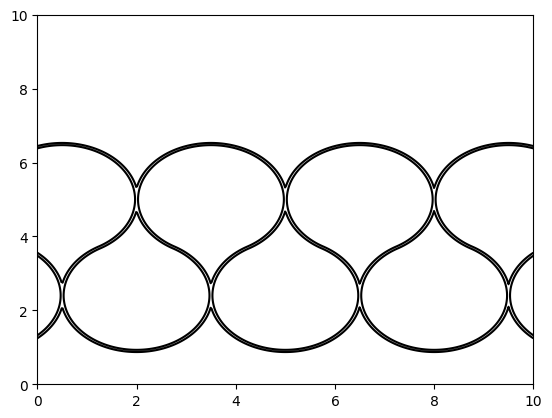

In [1214]:
#plot sdf_circle_wave
fig, ax = plt.subplots()
plt.xlim(0,10)
plt.ylim(0,10)
plot_sdf(ax, wave_sdf)
plt.show()

Running grid search for SDF function: wave_sdf
torch.Size([22, 2])
torch.Size([22, 2])
Epoch 0: loss = 33.030224829035085
Best Epoch 0: Best loss = 33.030224829035085
torch.Size([18, 2])
torch.Size([18, 2])
Epoch 1: loss = 16.95011746772171
Best Epoch 1: Best loss = 16.95011746772171
torch.Size([17, 2])
torch.Size([17, 2])
Epoch 2: loss = 105.70236073817281
Best Epoch 1: Best loss = 16.95011746772171
torch.Size([11, 2])
torch.Size([11, 2])
Epoch 3: loss = 12.371167572854311
Best Epoch 3: Best loss = 12.371167572854311
torch.Size([15, 2])
torch.Size([15, 2])
Epoch 4: loss = 81.09259136055309
Best Epoch 3: Best loss = 12.371167572854311
torch.Size([15, 2])
torch.Size([15, 2])
sites length:  128
upsampled sites length:  137
torch.Size([13, 2])
torch.Size([13, 2])
Epoch 6: loss = 76.60348067030334
Best Epoch 3: Best loss = 12.371167572854311
torch.Size([6, 2])
torch.Size([6, 2])
UPSAMPLED 1.0 Best Epoch 7: Best loss = 3.826723612896143
torch.Size([19, 2])
torch.Size([19, 2])
Epoch 8: loss 

IndexError: too many indices for tensor of dimension 1

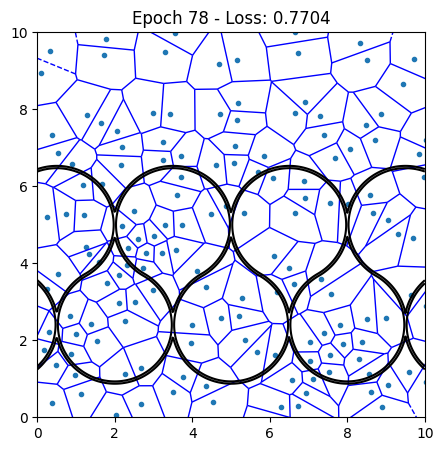

In [1215]:
# Example Usage
sdf_functions = [wave_sdf, moon_sdf, star_sdf, circle_sdf, box_sdf, torus_sdf]
weight_ranges = {
    'lambda_cvt': [0.0, 0.1, 0.5, 1.0],
    'lambda_sdf': [0.5, 1.0, 2.0],
    'lambda_min_distance': [0.0, 0.1, 0.5],
    'lambda_laplace': [0.5, 1.0, 2.0]
}
weight_ranges = {
    'lambda_cvt': [0.1],
    'lambda_sdf': [1.0],
    'lambda_min_distance': [0.1],
    'lambda_laplace': [0.5]
}

# Call the grid search function
results_df = grid_search_autograd(
    sites=sites,  # Replace with your starting sites
    sdf_functions=sdf_functions,
    weight_ranges=weight_ranges,
    learning_rate=learning_rate,
    max_iter=10,
    stop_train_threshold=stop_train_threshold
)

# Display the best combination
best_result = results_df.loc[results_df['final_loss'].idxmin()]
print("Best Hyperparameters:")
print(best_result)

Epoch 0: loss = 6959.490199083766
Best Epoch 0: Best loss = 6959.490199083766
Epoch 10: loss = 7.955889544220384
Best Epoch 7: Best loss = 2.576565888150798
Epoch 20: loss = 17.044858793897536
Best Epoch 14: Best loss = 1.526814506719015
Epoch 30: loss = 8.520107851025555
Best Epoch 14: Best loss = 1.526814506719015
Epoch 40: loss = 18.813427828453218
Best Epoch 14: Best loss = 1.526814506719015
sites length:  128
upsampled sites length:  179
Epoch 60: loss = 3.340137789903785
Best Epoch 14: Best loss = 1.526814506719015
UPSAMPLED 1.0 Best Epoch 66: Best loss = 1.4046523445323067
Epoch 80: loss = 1.8190804988960843
Best Epoch 66: Best loss = 1.4046523445323067
UPSAMPLED 1.0 Best Epoch 87: Best loss = 1.1917752034196623
UPSAMPLED 1.0 Best Epoch 88: Best loss = 1.0964511785764546
sites length:  179
upsampled sites length:  289
UPSAMPLED 2.0 Best Epoch 110: Best loss = 1.0231743710008738
UPSAMPLED 2.0 Best Epoch 116: Best loss = 0.9485445931340432
Epoch 120: loss = 1.7984907678619466
Best

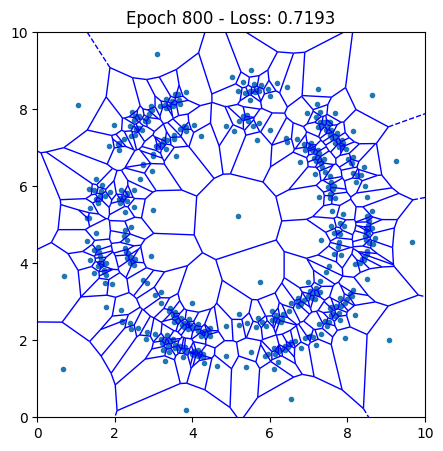

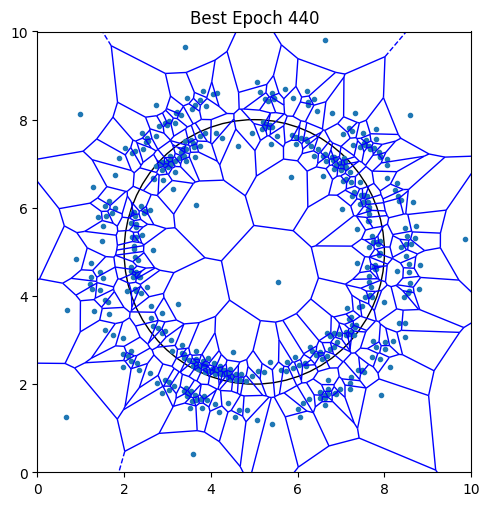

In [ ]:

sdf_fct = circle_sdf
#sdf_fct = box_sdf
#sdf_fct = torus_sdf

site_file_path = f'{destination}'f'{sdf_fct.__name__}_sites_{max_iter}.npy'

#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)
else:
    sites = autograd(sites, sdf_fct)
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)


print("Sites: ", sites)

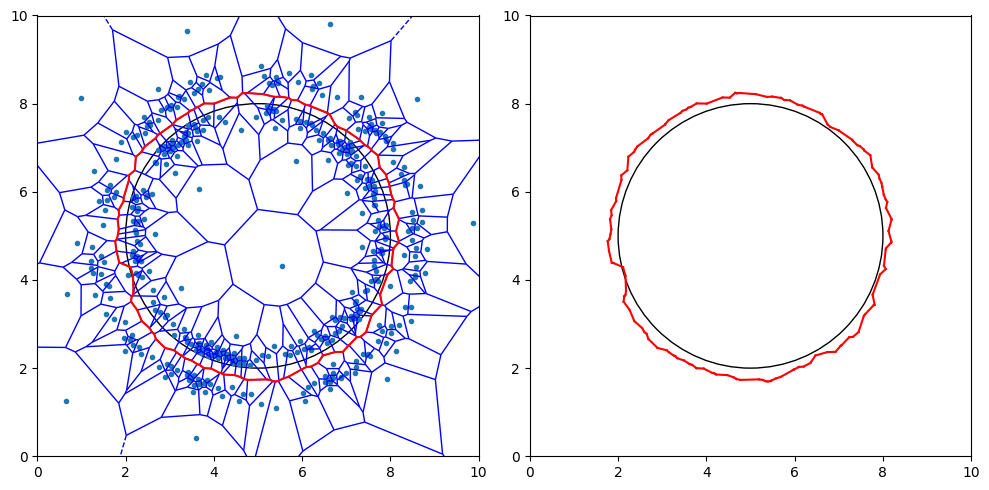

Edges:  [(50, 51), (54, 55), (38, 56), (55, 56), (51, 97), (148, 149), (89, 161), (159, 161), (89, 163), (162, 163), (38, 50), (130, 247), (246, 247), (225, 252), (224, 225), (252, 253), (171, 257), (255, 256), (256, 258), (257, 258), (155, 278), (278, 279), (277, 280), (279, 280), (277, 296), (295, 296), (159, 298), (298, 299), (191, 192), (191, 300), (148, 303), (162, 304), (303, 304), (166, 167), (167, 317), (96, 97), (323, 324), (179, 323), (54, 178), (171, 324), (178, 179), (299, 300), (110, 339), (338, 339), (342, 344), (192, 343), (342, 343), (338, 346), (344, 346), (36, 96), (402, 403), (253, 403), (251, 402), (245, 246), (130, 411), (411, 412), (425, 429), (429, 430), (210, 425), (423, 430), (154, 155), (154, 447), (447, 448), (149, 449), (448, 449), (272, 470), (295, 471), (470, 471), (504, 507), (507, 509), (508, 509), (317, 504), (489, 490), (489, 508), (490, 492), (111, 201), (201, 202), (36, 111), (363, 530), (528, 530), (363, 365), (351, 352), (352, 365), (202, 351), (11

In [ ]:
def get_sites_zero_crossing_edges(sites, sdf_fct):
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)

    # Compute SDF values for each site
    sdf_values = sdf_fct(sites)
    sdf_values = sdf_values.detach().cpu().numpy()

    edges = []
    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            edges.append((vertex1, vertex2))
    
    
        # Create two subplots: one with Voronoi diagram and one without
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot with Voronoi diagram
    ax1 = axs[0]
    voronoi_plot_2d(vor, ax=ax1, show_vertices=False, line_colors='blue')
    plot_sdf(ax1, sdf_fct)
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    #ax1.set_title("With Voronoi Diagram")

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vor.vertices[vertex1]
        v2 = vor.vertices[vertex2]
        ax1.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

    #ax1.legend(['Zero-crossing edges'], loc='upper right')

    # Plot without Voronoi diagram
    ax2 = axs[1]
    plot_sdf(ax2, sdf_fct)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    #ax2.set_title("Without Voronoi Diagram")
    #plt.triplot(*zip(*sites_np), 'o', markersize=3, color='blue')

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vor.vertices[vertex1]
        v2 = vor.vertices[vertex2]
        ax2.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

    #ax2.legend(['Zero-crossing edges'], loc='upper right')
    # plt.plot([], [], 'r-', label='sites zero-crossing edge')

    plt.tight_layout()
    plt.savefig(f'{destination}edge_sdf_crossing.png')
    
    plt.show()            
            
    return edges


edges = get_sites_zero_crossing_edges(sites, sdf_fct)

print("Edges: ", edges)


In [ ]:
def get_mesh_data_from_voronoi(sites, sdf_fct):
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)

    # Compute SDF values for each site
    sdf_values = sdf_fct(sites)
    sdf_values = sdf_values.detach().cpu().numpy()

    # Collect vertices, edges, and faces
    vertices = vor.vertices  # Unique vertices of the Voronoi diagram
    edges = []
    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            edges.append((vertex1, vertex2))
    
    return {
        "vertices": vertices,  # 2D positions of the vertices
        "edges": edges       # Connections between vertices
    }
    
    
# Example usage
mesh_data = get_mesh_data_from_voronoi(sites, sdf_fct)

# Access mesh components
vertices = mesh_data["vertices"]
edges = mesh_data["edges"]

print("Vertices:", vertices)
print("Edges:", edges)


Vertices: [[-3.7875485   2.51285764]
 [ 9.18154738  0.0492723 ]
 [ 5.89721738  5.48121223]
 ...
 [ 4.37408376  2.30668048]
 [ 4.34798106  2.46022166]
 [ 4.28020265  2.39269844]]
Edges: [(50, 51), (54, 55), (38, 56), (55, 56), (51, 97), (148, 149), (89, 161), (159, 161), (89, 163), (162, 163), (38, 50), (130, 247), (246, 247), (225, 252), (224, 225), (252, 253), (171, 257), (255, 256), (256, 258), (257, 258), (155, 278), (278, 279), (277, 280), (279, 280), (277, 296), (295, 296), (159, 298), (298, 299), (191, 192), (191, 300), (148, 303), (162, 304), (303, 304), (166, 167), (167, 317), (96, 97), (323, 324), (179, 323), (54, 178), (171, 324), (178, 179), (299, 300), (110, 339), (338, 339), (342, 344), (192, 343), (342, 343), (338, 346), (344, 346), (36, 96), (402, 403), (253, 403), (251, 402), (245, 246), (130, 411), (411, 412), (425, 429), (429, 430), (210, 425), (423, 430), (154, 155), (154, 447), (447, 448), (149, 449), (448, 449), (272, 470), (295, 471), (470, 471), (504, 507), (507,

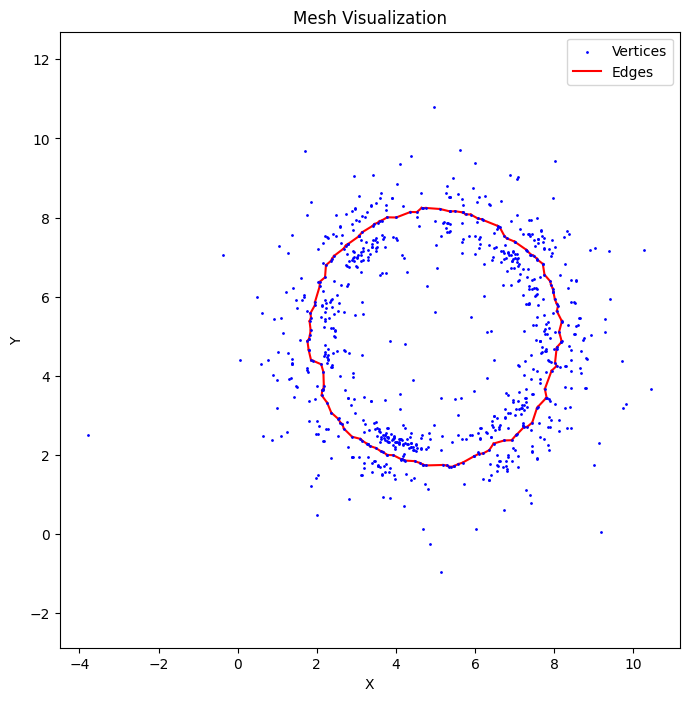

In [ ]:

def plot_mesh(mesh_data):
    vertices = mesh_data["vertices"]
    edges = mesh_data["edges"]

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], color='blue', label='Vertices', s=1, zorder=2)

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vertices[vertex1]
        v2 = vertices[vertex2]
        ax.plot([v1[0], v2[0]], [v1[1], v2[1]], color='red', label='Edges' if 'Edges' not in ax.get_legend_handles_labels()[1] else "", zorder=1)

    ax.set_title("Mesh Visualization")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.axis("equal")  # Ensures equal scaling for both axes
    ax.legend()
    plt.show()

# Example usage
plot_mesh(mesh_data)


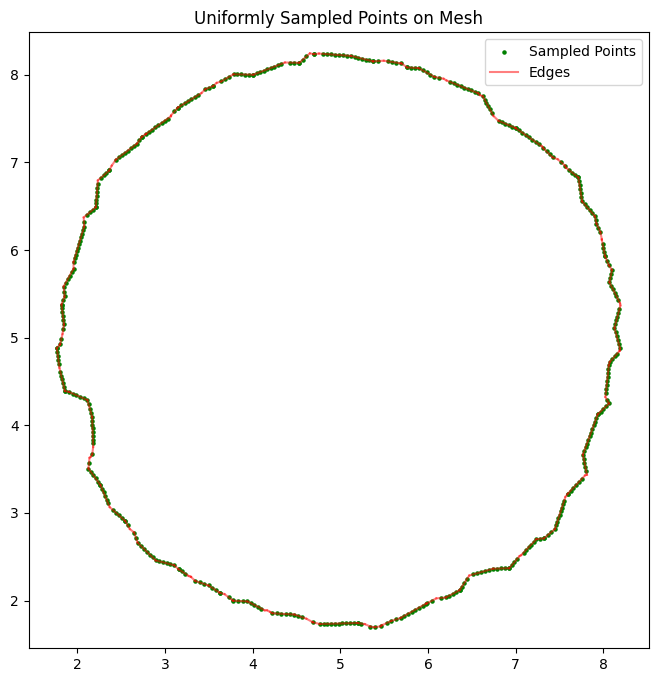

In [ ]:

# def uniform_sample_edges(vertices, edges, num_points):
#     # Compute edge lengths
#     edge_lengths = []
#     for vertex1, vertex2 in edges:
#         v1 = vertices[vertex1]
#         v2 = vertices[vertex2]
#         length = np.linalg.norm(v2 - v1)
#         edge_lengths.append(length)
    
#     edge_lengths = np.array(edge_lengths)
#     total_length = np.sum(edge_lengths)

#     # Determine the number of points to sample per edge
#     points_per_edge = (edge_lengths / total_length * num_points).astype(int)

#     # Sample points along each edge
#     sampled_points = []
#     for i, (vertex1, vertex2) in enumerate(edges):
#         v1 = vertices[vertex1]
#         v2 = vertices[vertex2]
#         num_edge_points = points_per_edge[i]

#         # Interpolate points along the edge
#         for t in np.linspace(0, 1, num_edge_points, endpoint=False):  # Exclude the endpoint to avoid duplicates
#             point = (1 - t) * v1 + t * v2
#             sampled_points.append(point)

#     return np.array(sampled_points)

# # Example usage
# num_samples = 500  # Total number of points to sample
# vertices = mesh_data["vertices"]
# edges = mesh_data["edges"]


# # Sample points on edges
# edge_points = uniform_sample_edges(vertices, edges, num_samples)

# # Combine sampled points
# all_sampled_points = edge_points


# plt.figure(figsize=(8, 8))
# plt.scatter(all_sampled_points[:, 0], all_sampled_points[:, 1], color="green", s=5, label="Sampled Points")
# #plt.scatter(vertices[:, 0], vertices[:, 1], color="blue", label="Vertices")
# for edge in edges:
#     v1, v2 = vertices[edge[0]], vertices[edge[1]]
#     plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color="red", alpha=0.5, label="Edges" if 'Edges' not in plt.gca().get_legend_handles_labels()[1] else "")
# plt.axis("equal")
# plt.legend()
# plt.title("Uniformly Sampled Points on Mesh")
# plt.show()
